## 1. Initial Setup and Library Imports

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.8 MB/s eta 0:00:00


In [4]:
# Import core libraries
import pandas as pd
import numpy as np
import math

# Import statistical libraries
from scipy.stats import skew
from scipy.stats import pointbiserialr, chi2 as chi2_dist # Alias chi2_dist to avoid conflict
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import scikit-learn utilities and models
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.svm import SVC

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import specific encoders and models
from category_encoders import TargetEncoder
import category_encoders as ce
from xgboost import XGBClassifier

# Import imbalanced-learn utilities
from collections import Counter # Also a standard Python library
from imblearn.over_sampling import ADASYN

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Data Loading

In [57]:
# Load primary datasets
employee_survey_df = pd.read_csv('employee_survey_data.csv')
general_df = pd.read_csv('general_data.csv')
manager_survey_df = pd.read_csv('manager_survey_data.csv')
print("Employee, general, and manager survey datasets loaded successfully.")

Employee, general, and manager survey datasets loaded successfully.


In [58]:
# Load time tracking datasets
in_time_df = pd.read_csv('in_time.csv')
out_time_df = pd.read_csv('out_time.csv')
print("In-time and out-time datasets loaded successfully.")

In-time and out-time datasets loaded successfully.


In [59]:
# Rename the first column (assumed to be EmployeeID if unnamed) for time data
in_time_df.rename(columns={in_time_df.columns[0]: 'EmployeeID'}, inplace=True)
out_time_df.rename(columns={out_time_df.columns[0]: 'EmployeeID'}, inplace=True)

## 3. Data Merging

In [60]:
# Merge the main datasets (general, employee survey, manager survey)
merged_df = general_df.merge(employee_survey_df, on='EmployeeID', how='left')\
                      .merge(manager_survey_df, on='EmployeeID', how='left')
print("Main datasets merged.")

Main datasets merged.


## 4. Feature Engineering - Attendance Data

In [61]:
# Separate EmployeeID before time conversion, and drop it from time dataframes
employee_ids_for_attendance = in_time_df['EmployeeID']
in_time = in_time_df.drop(columns=['EmployeeID'])
out_time = out_time_df.drop(columns=['EmployeeID'])

# Convert time columns to datetime objects, coercing errors to NaT (Not a Time)
in_time = in_time.apply(pd.to_datetime, errors='coerce')
out_time = out_time.apply(pd.to_datetime, errors='coerce')

# Calculate daily work hours in hours
work_hours = (out_time - in_time).apply(lambda x: x.dt.total_seconds() / 3600)
print("Daily work hours calculated.")

# Create attendance-related features
avg_work_hours = work_hours.mean(axis=1)  # Average work hours per employee across all recorded days
absent_days = work_hours.isnull().sum(axis=1)  # Count of days with missing time data (potential absences)
overtime_days = (work_hours > 9).sum(axis=1)  # Count of days where work hours exceeded 9 (assuming 9+ is overtime)

# Create a DataFrame for these new attendance features
attendance_features_df = pd.DataFrame({
    'EmployeeID': employee_ids_for_attendance,
    'AvgWorkHours': avg_work_hours,
    'AbsentDays': absent_days,
    'OverTime': overtime_days
})
print("Attendance features (AvgWorkHours, AbsentDays, OvertimeDays) created.")

# Merge attendance features into the main DataFrame
merged_df = merged_df.merge(attendance_features_df, on='EmployeeID', how='left')
print("Attendance features merged into the main dataset.")

# Display the first few rows of the fully merged dataset
print("\nFirst 5 rows of the merged dataset with attendance features:")
display(merged_df.head())

Daily work hours calculated.
Attendance features (AvgWorkHours, AbsentDays, OvertimeDays) created.
Attendance features merged into the main dataset.

First 5 rows of the merged dataset with attendance features:


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgWorkHours,AbsentDays,OverTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.000,Y,11,8,0,1.000,6,1,0,0,3.000,4.000,2.000,3,3,7.374,29,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.000,Y,23,8,1,6.000,3,5,1,4,3.000,2.000,4.000,2,4,7.719,25,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.000,Y,15,8,3,5.000,2,5,0,3,2.000,2.000,1.000,3,3,7.013,19,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.000,Y,11,8,3,13.000,5,8,7,5,4.000,4.000,3.000,2,3,7.194,26,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.000,Y,12,8,2,9.000,2,6,0,4,4.000,1.000,3.000,3,3,8.006,16,0


In [62]:
# Display general information about the merged dataset (data types, non-null counts, etc.)
print("Dataset Information:")
merged_df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  Num

In [63]:
# Identify categorical and numerical columns (initial classification)
cat_cols_initial = merged_df.select_dtypes(include=['object']).columns.tolist()
num_cols_initial = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define ordinal features (numerical in type, but often treated categorically or ordinally)
ordinal_as_cat_list = [
    'Education', 'JobLevel', 'StockOptionLevel',
    'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
    'JobInvolvement', 'PerformanceRating'
]

# Reclassify these ordinal features from numerical to categorical list
for col in ordinal_as_cat_list:
    if col in num_cols_initial:
        num_cols_initial.remove(col)
    if col not in cat_cols_initial:
        cat_cols_initial.append(col)

# Final lists of categorical and numerical columns
cat_cols = [c for c in cat_cols_initial if c in merged_df.columns]
num_cols = [c for c in num_cols_initial if c in merged_df.columns]

print("Categorical columns identified:")
print(cat_cols)
print("\nNumerical columns identified:")
print(num_cols)

Categorical columns identified:
['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating']

Numerical columns identified:
['Age', 'DistanceFromHome', 'EmployeeCount', 'EmployeeID', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AvgWorkHours', 'AbsentDays', 'OverTime']


In [64]:
# Display descriptive statistics for categorical columns
# For categorical columns, .describe() shows count, unique, top, freq.
print("\nDescriptive statistics for categorical columns:")
display(merged_df[cat_cols].astype('category').describe())

# Display descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
display(merged_df[num_cols].describe())


Descriptive statistics for categorical columns:


,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,Education,JobLevel,StockOptionLevel,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410,4410,4410,4410,4410,4410,4410,4410,4410,4410,4410,4385.000,4390.000,4372.000,4410,4410
unique,2,3,3,6,2,9,3,1,5,5,4,4.000,4.000,4.000,4,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,3,1,0,3.000,4.000,3.000,3,3
freq,3699,3129,2883,1818,2646,978,2019,4410,1716,1629,1893,1350.000,1367.000,2660.000,2604,3732



Descriptive statistics for numerical columns:


,Age,DistanceFromHome,EmployeeCount,EmployeeID,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,AvgWorkHours,AbsentDays,OverTime
count,4410.000,4410.000,4410.000,4410.000,4410.000,4391.000,4410.000,4410.000,4401.000,4410.000,4410.000,4410.000,4410.000,4410.000,4410.000,4410.000
mean,36.924,9.193,1.000,2205.500,65029.313,2.695,15.210,8.000,11.280,2.799,7.008,2.188,4.123,7.701,24.735,44.302
std,9.133,8.105,0.000,1273.202,47068.889,2.499,3.659,0.000,7.782,1.289,6.125,3.222,3.567,1.340,5.504,88.106
min,18.000,1.000,1.000,1.000,10090.000,0.000,11.000,8.000,0.000,0.000,0.000,0.000,0.000,5.951,13.000,0.000
25%,30.000,2.000,1.000,1103.250,29110.000,1.000,12.000,8.000,6.000,2.000,3.000,0.000,2.000,6.673,20.000,0.000
50%,36.000,7.000,1.000,2205.500,49190.000,2.000,14.000,8.000,10.000,3.000,5.000,1.000,3.000,7.407,25.000,0.000
75%,43.000,14.000,1.000,3307.750,83800.000,4.000,18.000,8.000,15.000,3.000,9.000,3.000,7.000,8.369,29.000,3.000
max,60.000,29.000,1.000,4410.000,199990.000,9.000,25.000,8.000,40.000,6.000,40.000,15.000,17.000,11.031,36.000,248.000


In [65]:
# Drop unnecessary or redundant columns
# EmployeeID is a unique identifier, not a feature for modeling.
# EmployeeCount, Over18, and StandardHours are constant values.
cols_to_drop = ['EmployeeID', 'EmployeeCount', 'StandardHours', 'Over18']
merged_df.drop(columns=cols_to_drop, inplace=True, errors='ignore') # errors='ignore' if a col was already dropped or not present
print(f"Dropped columns: \n{cols_to_drop}")

# Update column lists after dropping
cat_cols = [col for col in cat_cols if col not in cols_to_drop]
num_cols = [col for col in num_cols if col not in cols_to_drop]

print("\nRemaining columns after dropping:")
print(merged_df.columns.tolist())

Dropped columns: 
['EmployeeID', 'EmployeeCount', 'StandardHours', 'Over18']

Remaining columns after dropping:
['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'AvgWorkHours', 'AbsentDays', 'OverTime']


## 5. Data Wrangling

In [66]:
# Identify numerical and categorical columns
nominal_columns = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
ordinal_columns = ['PerformanceRating', 'JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction',
                   'EnvironmentSatisfaction', 'StockOptionLevel', 'JobLevel', 'Education']
cat_cols = nominal_columns + ordinal_columns
num_cols = [col for col in merged_df.select_dtypes(include=np.number).columns
            if col not in ordinal_columns + nominal_columns]

if 'Attrition' in cat_cols:
    cat_cols.remove('Attrition')

print(f"Numerical columns: {num_cols}")
print(f"Nominal columns (features): {cat_cols}")
print(f"Ordinal columns (features): {cat_cols}")

Numerical columns: ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AvgWorkHours', 'AbsentDays']
Nominal columns (features): ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction', 'EnvironmentSatisfaction', 'StockOptionLevel', 'JobLevel', 'Education']
Ordinal columns (features): ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction', 'EnvironmentSatisfaction', 'StockOptionLevel', 'JobLevel', 'Education']


### 5.1 Split Data
Splitting the data into training and testing sets with an 80:20 ratio. `stratify=y` ensures that the proportion of the target variable is maintained in both sets.

In [67]:
# Define features (X) and target (y)
X = merged_df.drop(columns=['Attrition'])
y = merged_df['Attrition']

# Split data into training and testing sets (80:20 ratio)
# random_state ensures reproducibility
# stratify=y ensures similar class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the dimensions of the resulting datasets
print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

Dimensions of X_train: (3528, 27)
Dimensions of X_test: (882, 27)
Dimensions of y_train: (3528,)
Dimensions of y_test: (882,)


### 5.2 Handling Duplicates
Checking for and reporting the number of duplicate rows in the original merged dataset.

In [68]:
# Count duplicate rows in the entire dataset before splitting
duplicate_rows_count = merged_df.duplicated().sum()
print(f"Number of duplicated rows in the original dataset: {duplicate_rows_count}")

Number of duplicated rows in the original dataset: 0


### 5.3 Handling Missing Values

Addressing missing values:
- Numerical features: Impute with the median of the column (calculated from the training set).
- Categorical features: Impute with the mode of the column (calculated from the training set).

In [69]:
# Create copies of the training and testing feature sets to avoid modifying the originals directly
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

In [70]:
# --- Calculate Skewness for Numerical Columns with Missing Values (in training set) ---
print("Skewness of numerical columns in X_train with missing values (before imputation):")
for col in num_cols:
    if X_train_clean[col].isna().sum() > 0:
        skewness = skew(X_train_clean[col].dropna())
        print(f"{col}: skew = {skewness:.2f}")

Skewness of numerical columns in X_train with missing values (before imputation):
NumCompaniesWorked: skew = 1.02
TotalWorkingYears: skew = 1.13


In [71]:
# --- Report Missing Values Before Handling ---
mv_train_before = X_train_clean.isna().sum()
mv_train_before = mv_train_before[mv_train_before > 0]
print("Missing values in X_train (before imputation):")
display(pd.DataFrame(mv_train_before, columns=["Missing Count"]))

mv_test_before = X_test_clean.isna().sum()
mv_test_before = mv_test_before[mv_test_before > 0]
print("\nMissing values in X_test (before imputation):")
display(pd.DataFrame(mv_test_before, columns=["Missing Count"]))

Missing values in X_train (before imputation):


,Missing Count
NumCompaniesWorked,16
TotalWorkingYears,7
EnvironmentSatisfaction,21
JobSatisfaction,19
WorkLifeBalance,26



Missing values in X_test (before imputation):


,Missing Count
NumCompaniesWorked,3
TotalWorkingYears,2
EnvironmentSatisfaction,4
JobSatisfaction,1
WorkLifeBalance,12


In [72]:
# --- Impute Missing Values ---
# Numerical features: Impute with median (calculated from training set)
for col in num_cols:
    if X_train_clean[col].isna().any():
        median_value = X_train_clean[col].median()
        X_train_clean[col] = X_train_clean[col].fillna(median_value)
        X_test_clean[col] = X_test_clean[col].fillna(median_value)

# Categorical features: Impute with mode (calculated from training set)
for col in cat_cols:
    if X_train_clean[col].isna().any():
        mode_value = X_train_clean[col].mode()[0]
        original_dtype_train = X_train_clean[col].dtype
        original_dtype_test = X_test_clean[col].dtype

        X_train_clean[col] = X_train_clean[col].fillna(mode_value).astype(original_dtype_train)
        X_test_clean[col] = X_test_clean[col].fillna(mode_value).astype(original_dtype_test) # Use train mode for test set

In [73]:
# --- Report Missing Values After Handling ---
mv_train_after = X_train_clean.isna().sum()
mv_train_after = mv_train_after[mv_train_after > 0]
print("Missing values in X_train (after imputation):")
display(pd.DataFrame(mv_train_after, columns=["Missing Count"]))

mv_test_after = X_test_clean.isna().sum()
mv_test_after = mv_test_after[mv_test_after > 0]
print("\nMissing values in X_test (after imputation):")
display(pd.DataFrame(mv_test_after, columns=["Missing Count"]))

Missing values in X_train (after imputation):


,Missing Count



Missing values in X_test (after imputation):


,Missing Count


### 5.4 Encoding Categorical Features
Converting categorical features into numerical representations:
- **Nominal Features**: Use One-Hot Encoding. `drop_first=True` is used to avoid multicollinearity.
- **Ordinal Features**: Use Ordinal Encoding with predefined categories to maintain order.

In [74]:
# Define nominal and ordinal columns based on your dataset's characteristics
nominal_columns = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
ordinal_columns = ['PerformanceRating', 'JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction',
                   'EnvironmentSatisfaction', 'StockOptionLevel', 'JobLevel', 'Education']

# Ensure all defined columns exist in the cleaned data, filter if not
nominal_columns = [col for col in nominal_columns if col in X_train_clean.columns]
ordinal_columns = [col for col in ordinal_columns if col in X_train_clean.columns]

# Create copies for encoding
X_train_enc = X_train_clean.copy()
X_test_enc = X_test_clean.copy()

In [75]:
# --- One-Hot Encoding for Nominal Features ---
print("--- ONE-HOT ENCODING for Nominal Columns ---")
X_train_enc = pd.get_dummies(X_train_enc, columns=nominal_columns, drop_first=True, dummy_na=False) # dummy_na=False by default
X_test_enc = pd.get_dummies(X_test_enc, columns=nominal_columns, drop_first=True, dummy_na=False)

# Convert boolean columns created by get_dummies (if any with True/False) to int (0/1)
bool_cols_train = X_train_enc.select_dtypes(include='bool').columns
X_train_enc[bool_cols_train] = X_train_enc[bool_cols_train].astype(int)

bool_cols_test = X_test_enc.select_dtypes(include='bool').columns
X_test_enc[bool_cols_test] = X_test_enc[bool_cols_test].astype(int)

print(f"Number of features after One-Hot Encoding (train): {X_train_enc.shape[1]}")
print(f"Number of features after One-Hot Encoding (test): {X_test_enc.shape[1]}")

# --- Ordinal Encoding for Ordinal Features ---
print("\n--- ORDINAL ENCODING for Ordinal Columns ---")
# Define the specific order for each ordinal column
ordinal_categories_mapping = {
  'PerformanceRating': [1, 2, 3, 4],
  'JobInvolvement': [1, 2, 3, 4],
  'WorkLifeBalance': [1, 2, 3, 4],
  'JobSatisfaction': [1, 2, 3, 4],
  'EnvironmentSatisfaction': [1, 2, 3, 4],
  'StockOptionLevel': [0, 1, 2, 3],
  'JobLevel': [1, 2, 3, 4, 5],
  'Education': [1, 2, 3, 4, 5] # 1:Below College, 2:College, 3:Bachelor, 4:Master, 5:Doctor
}

# Filter categories for columns that are actually present
ordinal_categories_list = [ordinal_categories_mapping[col] for col in ordinal_columns if col in ordinal_categories_mapping]

if ordinal_categories_list: # Proceed if there are categories defined for present ordinal columns
  oe = OrdinalEncoder(categories=ordinal_categories_list,
            handle_unknown='use_encoded_value',
            unknown_value=-1) # Assign -1 to unknown values

# Fit on training data and transform both training and testing data
X_train_enc[ordinal_columns] = oe.fit_transform(X_train_clean[ordinal_columns])
X_test_enc[ordinal_columns] = oe.transform(X_test_clean[ordinal_columns])

# Align columns between train and test sets after one-hot encoding (important if some categories appear only in one set)
train_cols = X_train_enc.columns
test_cols = X_test_enc.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_enc[c] = 0 # Add missing columns to test set, fill with 0 (as they were not present)

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_enc[c] = 0 # Add missing columns to train set, fill with 0

X_test_enc = X_test_enc[train_cols] # Ensure test set has same columns and order as train set

print(f"\nNumber of features after all encoding (train): {X_train_enc.shape[1]}")
print(f"Number of features after all encoding (test): {X_test_enc.shape[1]}")

print("\nExample of X_train after encoding:")
display(X_train_enc.head())

--- ONE-HOT ENCODING for Nominal Columns ---
Number of features after One-Hot Encoding (train): 231
Number of features after One-Hot Encoding (test): 130

--- ORDINAL ENCODING for Ordinal Columns ---

Number of features after all encoding (train): 243
Number of features after all encoding (test): 231

Example of X_train after encoding:


<ipython-input-75-1813edcd1be5>:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_enc[c] = 0 # Add missing columns to test set, fill with 0 (as they were not present)
<ipython-input-75-1813edcd1be5>:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_enc[c] = 0 # Add missing columns to test set, fill with 0 (as they were not present)
<ipython-input-75-1813edcd1be5>:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgWorkHours,AbsentDays,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_1,OverTime_2,OverTime_3,OverTime_4,OverTime_5,OverTime_6,OverTime_7,OverTime_8,OverTime_9,OverTime_10,OverTime_11,OverTime_12,OverTime_13,OverTime_14,OverTime_16,OverTime_17,OverTime_18,OverTime_19,OverTime_21,OverTime_22,OverTime_23,OverTime_24,OverTime_25,OverTime_26,OverTime_27,OverTime_28,OverTime_29,OverTime_30,OverTime_31,OverTime_32,OverTime_33,OverTime_34,OverTime_35,OverTime_36,OverTime_37,OverTime_38,OverTime_39,OverTime_40,OverTime_42,OverTime_43,OverTime_44,OverTime_45,OverTime_47,OverTime_48,OverTime_50,OverTime_51,OverTime_52,OverTime_53,OverTime_54,OverTime_55,OverTime_56,OverTime_57,OverTime_58,OverTime_59,OverTime_60,OverTime_61,OverTime_63,OverTime_64,OverTime_67,OverTime_68,OverTime_71,OverTime_73,OverTime_74,OverTime_75,OverTime_77,OverTime_78,OverTime_79,OverTime_80,OverTime_81,OverTime_82,OverTime_83,OverTime_85,OverTime_86,OverTime_87,OverTime_88,OverTime_89,OverTime_90,OverTime_91,OverTime_92,OverTime_93,OverTime_94,OverTime_95,OverTime_96,OverTime_97,OverTime_98,OverTime_100,OverTime_101,OverTime_106,OverTime_110,OverTime_112,OverTime_114,OverTime_115,OverTime_116,OverTime_117,OverTime_119,OverTime_122,OverTime_123,OverTime_124,OverTime_126,OverTime_127,OverTime_130,OverTime_131,OverTime_134,OverTime_137,OverTime_139,OverTime_140,OverTime_142,OverTime_143,OverTime_145,OverTime_148,OverTime_149,OverTime_150,OverTime_151,OverTime_152,OverTime_153,OverTime_155,OverTime_158,OverTime_159,OverTime_163,OverTime_164,OverTime_166,OverTime_167,OverTime_168,OverTime_169,OverTime_170,OverTime_171,OverTime_173,OverTime_177,OverTime_178,OverTime_179,OverTime_181,OverTime_182,OverTime_183,OverTime_187,OverTime_188,OverTime_189,OverTime_190,OverTime_191,OverTime_192,OverTime_193,OverTime_194,OverTime_195,OverTime_196,OverTime_197,OverTime_198,OverTime_199,OverTime_200,OverTime_201,OverTime_203,OverTime_204,OverTime_206,OverTime_207,OverTime_208,OverTime_210,OverTime_211,OverTime_213,OverTime_214,OverTime_215,OverTime_216,OverTime_217,OverTime_218,OverTime_219,OverTime_220,OverTime_221,OverTime_222,OverTime_223,OverTime_224,OverTime_225,OverTime_226,OverTime_227,OverTime_228,OverTime_229,OverTime_230,OverTime_231,OverTime_232,OverTime_233,OverTime_234,OverTime_235,OverTime_236,OverTime_237,OverTime_238,OverTime_239,OverTime_240,OverTime_241,OverTime_242,OverTime_243,OverTime_244,OverTime_245,OverTime_246,OverTime_247,OverTime_248,OverTime_180,OverTime_133,OverTime_147,OverTime_186,OverTime_156,OverTime_125,OverTime_175,OverTime_15,OverTime_144,OverTime_113,OverTime_41,OverTime_154
3465,41,1,3.000,0.000,52570,1.000,14,0.000,10.000,2,10,0,8,1.000,2.000,2.000,3.000,2.000,7.910,20,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3485,34,1,0.000,1.000,26960,3.000,23,0.000,6.000,3,0,0,0,2.000,3.000,2.000,2.000,3.000

### 5.5 Feature Transformation
Applying Yeo-Johnson power transformation to specified numerical features to reduce skewness and make their distributions more Gaussian-like. Setting standardize=True then scales these transformed features to have a mean of 0 and a standard deviation of 1. This can improve the performance of some machine learning models.

In [76]:
# --- Calculate Skewness of Numerical Features in the Original Merged Dataset ---
# This helps identify which columns might benefit from transformation.
skew_values = {}
for col in num_cols: # Check only numeric types
    col_data = merged_df[col].dropna()
    if not col_data.empty:
        skew_values[col] = skew(col_data)

skew_merged_df = pd.DataFrame(list(skew_values.items()), columns=['Column', 'Skewness'])
print("Skewness of numerical features in the original dataset:")
display(skew_merged_df.sort_values(by='Skewness', key=abs, ascending=False))

Skewness of numerical features in the original dataset:


,Column,Skewness
8,YearsSinceLastPromotion,1.982
7,YearsAtCompany,1.763
2,MonthlyIncome,1.368
5,TotalWorkingYears,1.116
3,NumCompaniesWorked,1.026
1,DistanceFromHome,0.957
10,AvgWorkHours,0.863
9,YearsWithCurrManager,0.833
4,PercentSalaryHike,0.820
6,TrainingTimesLastYear,0.553


--- Distribution Visualization (Before vs. After Transformation) ---


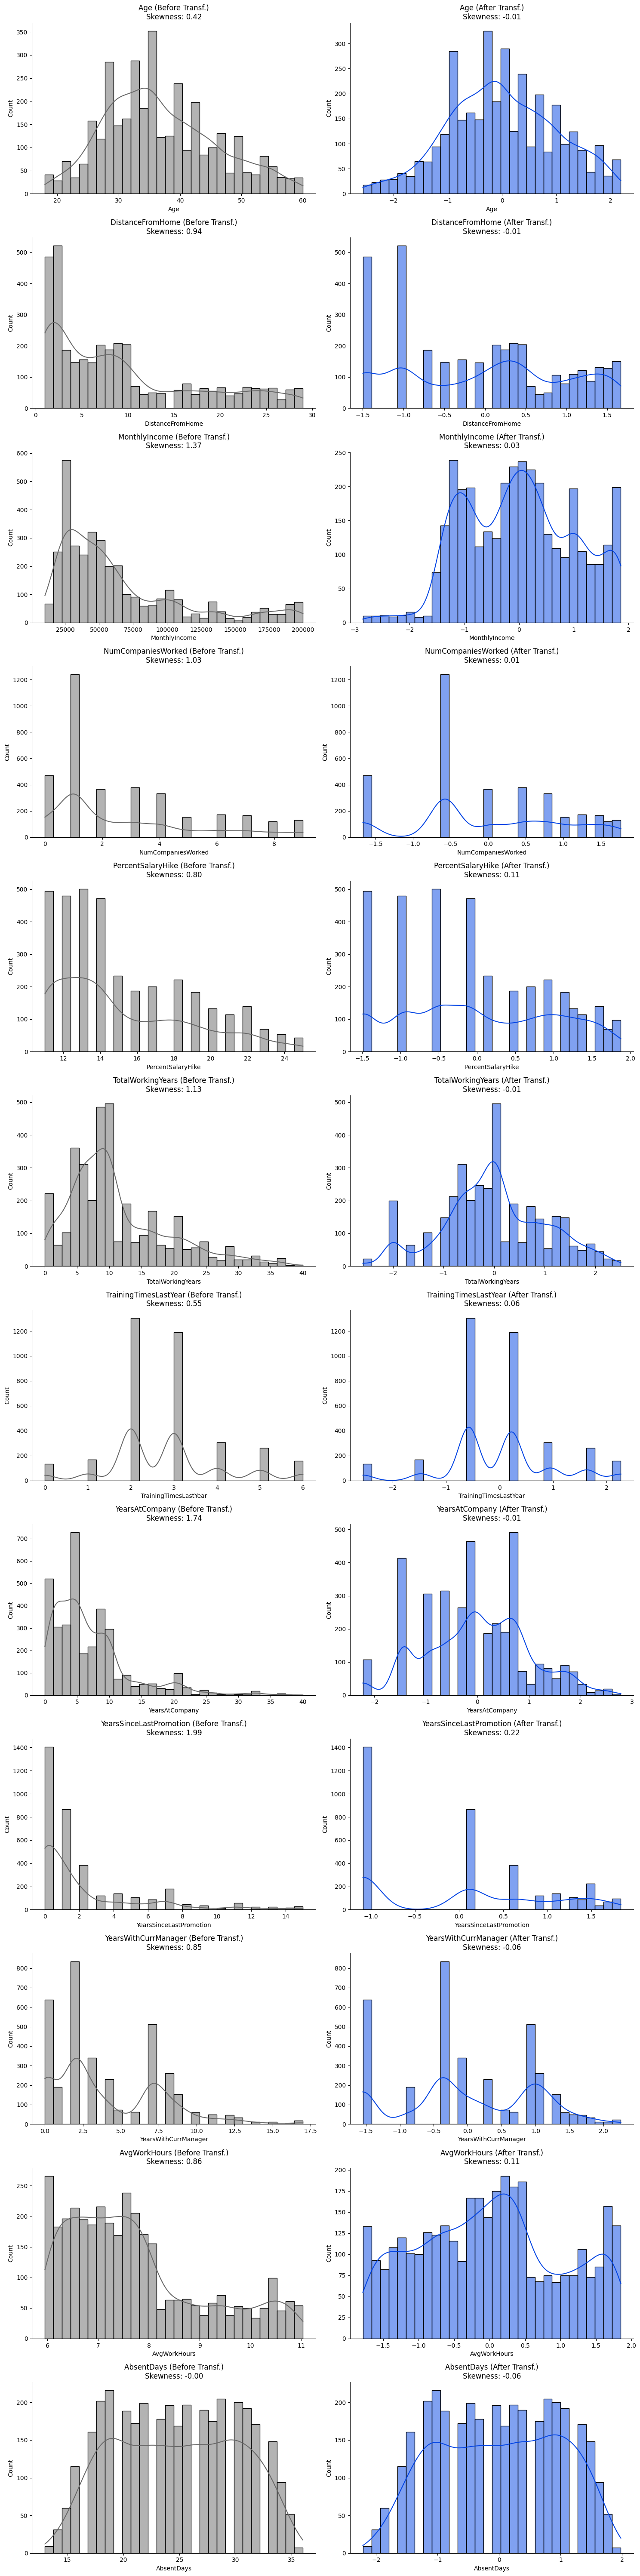

Dataset head after Feature Transformation (X_train_transformed):


,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgWorkHours,AbsentDays,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_1,OverTime_2,OverTime_3,OverTime_4,OverTime_5,OverTime_6,OverTime_7,OverTime_8,OverTime_9,OverTime_10,OverTime_11,OverTime_12,OverTime_13,OverTime_14,OverTime_16,OverTime_17,OverTime_18,OverTime_19,OverTime_21,OverTime_22,OverTime_23,OverTime_24,OverTime_25,OverTime_26,OverTime_27,OverTime_28,OverTime_29,OverTime_30,OverTime_31,OverTime_32,OverTime_33,OverTime_34,OverTime_35,OverTime_36,OverTime_37,OverTime_38,OverTime_39,OverTime_40,OverTime_42,OverTime_43,OverTime_44,OverTime_45,OverTime_47,OverTime_48,OverTime_50,OverTime_51,OverTime_52,OverTime_53,OverTime_54,OverTime_55,OverTime_56,OverTime_57,OverTime_58,OverTime_59,OverTime_60,OverTime_61,OverTime_63,OverTime_64,OverTime_67,OverTime_68,OverTime_71,OverTime_73,OverTime_74,OverTime_75,OverTime_77,OverTime_78,OverTime_79,OverTime_80,OverTime_81,OverTime_82,OverTime_83,OverTime_85,OverTime_86,OverTime_87,OverTime_88,OverTime_89,OverTime_90,OverTime_91,OverTime_92,OverTime_93,OverTime_94,OverTime_95,OverTime_96,OverTime_97,OverTime_98,OverTime_100,OverTime_101,OverTime_106,OverTime_110,OverTime_112,OverTime_114,OverTime_115,OverTime_116,OverTime_117,OverTime_119,OverTime_122,OverTime_123,OverTime_124,OverTime_126,OverTime_127,OverTime_130,OverTime_131,OverTime_134,OverTime_137,OverTime_139,OverTime_140,OverTime_142,OverTime_143,OverTime_145,OverTime_148,OverTime_149,OverTime_150,OverTime_151,OverTime_152,OverTime_153,OverTime_155,OverTime_158,OverTime_159,OverTime_163,OverTime_164,OverTime_166,OverTime_167,OverTime_168,OverTime_169,OverTime_170,OverTime_171,OverTime_173,OverTime_177,OverTime_178,OverTime_179,OverTime_181,OverTime_182,OverTime_183,OverTime_187,OverTime_188,OverTime_189,OverTime_190,OverTime_191,OverTime_192,OverTime_193,OverTime_194,OverTime_195,OverTime_196,OverTime_197,OverTime_198,OverTime_199,OverTime_200,OverTime_201,OverTime_203,OverTime_204,OverTime_206,OverTime_207,OverTime_208,OverTime_210,OverTime_211,OverTime_213,OverTime_214,OverTime_215,OverTime_216,OverTime_217,OverTime_218,OverTime_219,OverTime_220,OverTime_221,OverTime_222,OverTime_223,OverTime_224,OverTime_225,OverTime_226,OverTime_227,OverTime_228,OverTime_229,OverTime_230,OverTime_231,OverTime_232,OverTime_233,OverTime_234,OverTime_235,OverTime_236,OverTime_237,OverTime_238,OverTime_239,OverTime_240,OverTime_241,OverTime_242,OverTime_243,OverTime_244,OverTime_245,OverTime_246,OverTime_247,OverTime_248,OverTime_180,OverTime_133,OverTime_147,OverTime_186,OverTime_156,OverTime_125,OverTime_175,OverTime_15,OverTime_144,OverTime_113,OverTime_41,OverTime_154
3465,0.538,-1.499,3.000,0.000,0.099,-0.575,-0.136,0.000,0.058,-0.575,0.776,-1.091,1.100,1.000,2.000,2.000,3.000,2.000,0.402,-0.848,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3485,-0.221,-1.499,0.000,1.000,-0.978,0.465,1.668,0.0


Dimensions after Feature Transformation (X_train): (3528, 243)
Dimensions after Feature Transformation (X_test): (882, 231)


In [77]:
# --- Apply Yeo-Johnson Transformation ---
X_train_transformed = X_train_enc.copy()
X_test_transformed = X_test_enc.copy()

pt = PowerTransformer(method='yeo-johnson', standardize=True) # Standardize=True centers and scales data after transformation

# Fit transformer on the training data and transform both train and test sets
X_train_transformed[num_cols] = pt.fit_transform(X_train_enc[num_cols])
X_test_transformed[num_cols] = pt.transform(X_test_enc[num_cols])

# --- Visualize Distribution Before and After Transformation (for training data) ---
print("--- Distribution Visualization (Before vs. After Transformation) ---")
num_features_to_plot = len(num_cols)
num_plot_rows = (num_features_to_plot * 2 + 1) // 2

plt.figure(figsize=(15, 5 * num_plot_rows))
for i, col in enumerate(num_cols):
  # Plot Before Transformation
  plt.subplot(num_plot_rows, 2, i * 2 + 1)
  sns.histplot(X_train_enc[col], kde=True, bins=30, color='dimgray', edgecolor='black')
  plt.title(f'{col} (Before Transf.)\nSkewness: {skew(X_train_enc[col]):.2f}')
  plt.xlabel(col)
  plt.ylabel('Count')
  sns.despine()

  # Plot After Transformation
  plt.subplot(num_plot_rows, 2, i * 2 + 2)
  sns.histplot(X_train_transformed[col], kde=True, bins=30, color='#0345e4', edgecolor='black')
  plt.title(f'{col} (After Transf.)\nSkewness: {skew(X_train_transformed[col]):.2f}')
  plt.xlabel(col)
  plt.ylabel('Count')
  sns.despine()

plt.tight_layout()
plt.show()

# --- Output Transformed Data Information ---
print("Dataset head after Feature Transformation (X_train_transformed):")
display(X_train_transformed.head())
print(f"\nDimensions after Feature Transformation (X_train): {X_train_transformed.shape}")
print(f"Dimensions after Feature Transformation (X_test): {X_test_transformed.shape}")

### 5.6 Handling Outliers

Detecting and handling outliers using the Interquartile Range (IQR) method.
- Outliers are identified as values below $Q1 - 1.5 \times IQR$ or above $Q3 + 1.5 \times IQR$.
- **Capping**: Outliers are capped at these lower and upper bounds. This is done for numerical features with more than 10 unique values to avoid affecting binary or low-cardinality encoded features.

--- Outlier Visualization (Before vs. After Capping) ---


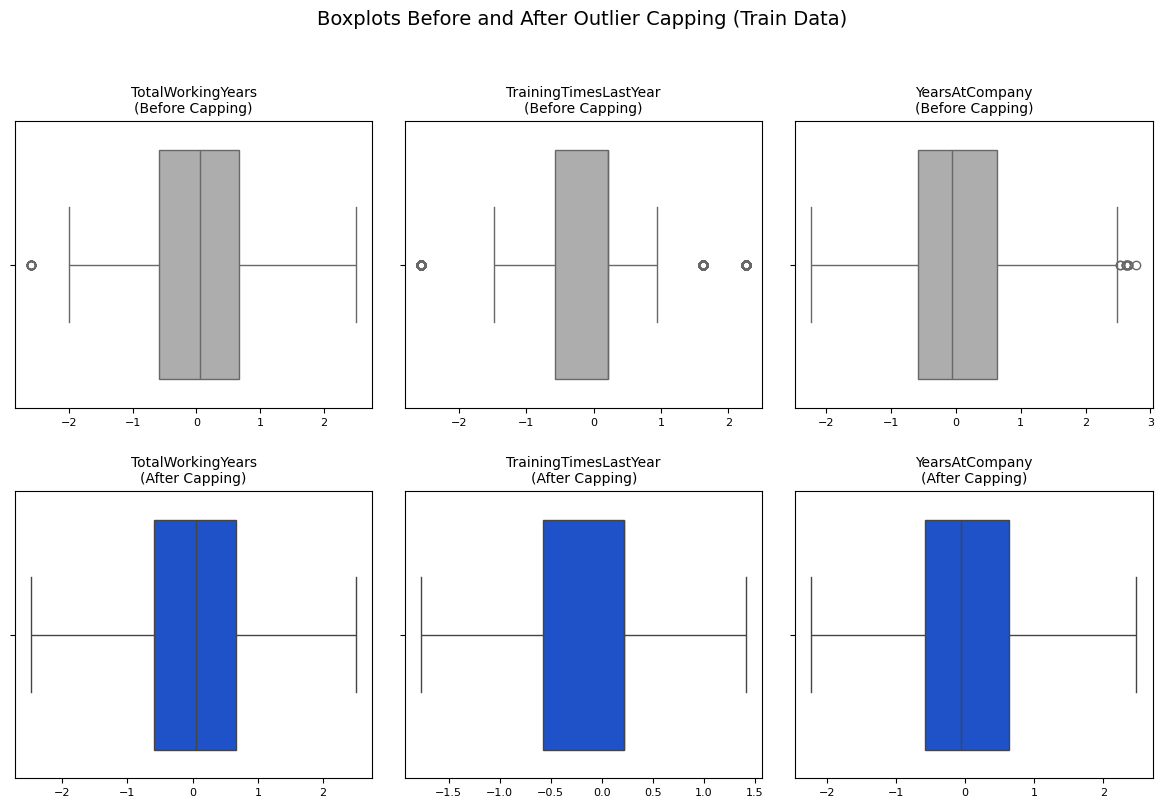


--- Summary of Outlier Capping (for all checked numerical features with >10 unique values) ---


,Column,Train_Values_Count,Values_Capped_Count,Values_Capped_%,Lower_Bound_Used,Upper_Bound_Used,Outliers_Capped
0,Age,3528,0,0.00%,-2.880,2.910,No
1,DistanceFromHome,3528,0,0.00%,-3.850,3.640,No
2,MonthlyIncome,3528,0,0.00%,-3.300,3.200,No
3,NumCompaniesWorked,3528,0,0.00%,-2.620,2.840,No
4,PercentSalaryHike,3528,0,0.00%,-3.760,3.720,No
5,TotalWorkingYears,3528,23,0.65%,-2.470,2.540,Yes
6,TrainingTimesLastYear,3528,556,15.76%,-1.770,1.420,Yes
7,YearsAtCompany,3528,10,0.28%,-2.420,2.480,Yes
8,YearsSinceLastPromotion,3528,0,0.00%,-3.660,3.200,No
9,YearsWithCurrManager,3528,0,0.00%,-2.360,2.890,No



Dataset head after Outlier Handling (X_train_out):


,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgWorkHours,AbsentDays,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_1,OverTime_2,OverTime_3,OverTime_4,OverTime_5,OverTime_6,OverTime_7,OverTime_8,OverTime_9,OverTime_10,OverTime_11,OverTime_12,OverTime_13,OverTime_14,OverTime_16,OverTime_17,OverTime_18,OverTime_19,OverTime_21,OverTime_22,OverTime_23,OverTime_24,OverTime_25,OverTime_26,OverTime_27,OverTime_28,OverTime_29,OverTime_30,OverTime_31,OverTime_32,OverTime_33,OverTime_34,OverTime_35,OverTime_36,OverTime_37,OverTime_38,OverTime_39,OverTime_40,OverTime_42,OverTime_43,OverTime_44,OverTime_45,OverTime_47,OverTime_48,OverTime_50,OverTime_51,OverTime_52,OverTime_53,OverTime_54,OverTime_55,OverTime_56,OverTime_57,OverTime_58,OverTime_59,OverTime_60,OverTime_61,OverTime_63,OverTime_64,OverTime_67,OverTime_68,OverTime_71,OverTime_73,OverTime_74,OverTime_75,OverTime_77,OverTime_78,OverTime_79,OverTime_80,OverTime_81,OverTime_82,OverTime_83,OverTime_85,OverTime_86,OverTime_87,OverTime_88,OverTime_89,OverTime_90,OverTime_91,OverTime_92,OverTime_93,OverTime_94,OverTime_95,OverTime_96,OverTime_97,OverTime_98,OverTime_100,OverTime_101,OverTime_106,OverTime_110,OverTime_112,OverTime_114,OverTime_115,OverTime_116,OverTime_117,OverTime_119,OverTime_122,OverTime_123,OverTime_124,OverTime_126,OverTime_127,OverTime_130,OverTime_131,OverTime_134,OverTime_137,OverTime_139,OverTime_140,OverTime_142,OverTime_143,OverTime_145,OverTime_148,OverTime_149,OverTime_150,OverTime_151,OverTime_152,OverTime_153,OverTime_155,OverTime_158,OverTime_159,OverTime_163,OverTime_164,OverTime_166,OverTime_167,OverTime_168,OverTime_169,OverTime_170,OverTime_171,OverTime_173,OverTime_177,OverTime_178,OverTime_179,OverTime_181,OverTime_182,OverTime_183,OverTime_187,OverTime_188,OverTime_189,OverTime_190,OverTime_191,OverTime_192,OverTime_193,OverTime_194,OverTime_195,OverTime_196,OverTime_197,OverTime_198,OverTime_199,OverTime_200,OverTime_201,OverTime_203,OverTime_204,OverTime_206,OverTime_207,OverTime_208,OverTime_210,OverTime_211,OverTime_213,OverTime_214,OverTime_215,OverTime_216,OverTime_217,OverTime_218,OverTime_219,OverTime_220,OverTime_221,OverTime_222,OverTime_223,OverTime_224,OverTime_225,OverTime_226,OverTime_227,OverTime_228,OverTime_229,OverTime_230,OverTime_231,OverTime_232,OverTime_233,OverTime_234,OverTime_235,OverTime_236,OverTime_237,OverTime_238,OverTime_239,OverTime_240,OverTime_241,OverTime_242,OverTime_243,OverTime_244,OverTime_245,OverTime_246,OverTime_247,OverTime_248,OverTime_180,OverTime_133,OverTime_147,OverTime_186,OverTime_156,OverTime_125,OverTime_175,OverTime_15,OverTime_144,OverTime_113,OverTime_41,OverTime_154
3465,0.538,-1.499,3.000,0.000,0.099,-0.575,-0.136,0.000,0.058,-0.575,0.776,-1.091,1.100,1.000,2.000,2.000,3.000,2.000,0.402,-0.848,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3485,-0.221,-1.499,0.000,1.000,-0.978,0.465,1.668,0.0


Dimensions after Outlier Handling (X_train_out): (3528, 243)
Dimensions after Outlier Handling (X_test_out): (882, 231)


In [78]:
# Create copies for outlier handling
X_train_out = X_train_transformed.copy()
X_test_out = X_test_transformed.copy()

outlier_info_capping = {}
columns_with_outliers_found = [] # Store columns that actually had outliers capped

for col in num_cols:
    # Calculate Q1, Q3, and IQR from the training data
    Q1 = X_train_transformed[col].quantile(0.25)
    Q3 = X_train_transformed[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before capping (in training data)
    outliers_original_train = ((X_train_transformed[col] < lower_bound) | (X_train_transformed[col] > upper_bound))
    outliers_to_cap_count = outliers_original_train.sum()

    if outliers_to_cap_count > 0:
        columns_with_outliers_found.append(col)

    outliers_to_cap_percent = (outliers_to_cap_count / len(X_train_transformed)) * 100

    outlier_info_capping[col] = {
        'count_to_be_capped': outliers_to_cap_count,
        'percentage_to_be_capped': outliers_to_cap_percent,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'has_outliers_for_capping': outliers_to_cap_count > 0
    }

    # Apply capping to both training and test sets using bounds from training data
    X_train_out[col] = X_train_out[col].clip(lower=lower_bound, upper=upper_bound)
    X_test_out[col] = X_test_out[col].clip(lower=lower_bound, upper=upper_bound)

# --- Visualize Outliers Before and After Capping (for columns where outliers were found) ---
print("--- Outlier Visualization (Before vs. After Capping) ---")
num_features_to_plot = len(columns_with_outliers_found)
fig_width = max(num_features_to_plot * 4, 10) # Adjust width based on number of features
fig_height = 8 # Fixed height for two rows of plots

plt.figure(figsize=(fig_width, fig_height))

# First row: Boxplots before capping
for i, col in enumerate(columns_with_outliers_found):
  plt.subplot(2, num_features_to_plot, i + 1)
  sns.boxplot(x=X_train_transformed[col], color='#adadad', orient='h')
  plt.title(f'{col}\n(Before Capping)', fontsize=10)
  plt.ylabel('')
  plt.xlabel('')
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)

    # Second row: Boxplots after capping
for i, col in enumerate(columns_with_outliers_found):
  plt.subplot(2, num_features_to_plot, num_features_to_plot + i + 1)
  sns.boxplot(x=X_train_out[col], color='#0345e4', orient='h')
  plt.title(f'{col}\n(After Capping)', fontsize=10)
  plt.ylabel('')
  plt.xlabel('')
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96], pad=2.0) # Adjust layout and add padding
plt.suptitle('Boxplots Before and After Outlier Capping (Train Data)', fontsize=14, y=1.02)
plt.show()

# --- Summary of Capping ---
summary_capping_list = []
for col in num_cols: # Iterate over all checked columns for the summary
    info = outlier_info_capping[col]
    summary_capping_list.append({
        'Column': col,
        'Train_Values_Count': len(X_train_transformed),
        'Values_Capped_Count': info['count_to_be_capped'],
        'Values_Capped_%': f"{info['percentage_to_be_capped']:.2f}%",
        'Lower_Bound_Used': round(info['lower_bound'], 2),
        'Upper_Bound_Used': round(info['upper_bound'], 2),
        'Outliers_Capped': 'Yes' if info['has_outliers_for_capping'] else 'No'
    })

summary_capping_df = pd.DataFrame(summary_capping_list)
print("\n--- Summary of Outlier Capping (for all checked numerical features with >10 unique values) ---")
display(summary_capping_df)

print("\nDataset head after Outlier Handling (X_train_out):")
display(X_train_out.head())
print(f"\nDimensions after Outlier Handling (X_train_out): {X_train_out.shape}")
print(f"Dimensions after Outlier Handling (X_test_out): {X_test_out.shape}")

### 5.7 Handling Imbalanced Class

Addressing class imbalance in the target variable (`y_train`) using the ADASYN (Adaptive Synthetic Sampling) technique. This is applied only to the training data to prevent data leakage into the test set.

In [79]:
# --- Check Class Distribution Before Resampling ---
print("Class distribution in y_train before ADASYN:", Counter(y_train))

# --- Apply ADASYN for Resampling ---
# ADASYN is an oversampling technique that generates synthetic samples for the minority class.
# It is applied only to the training data.
adasyn = ADASYN(random_state=42)

# Ensure y_train is in a format suitable for ADASYN
y_train_mapped = y_train.map({'Yes': 1, 'No': 0})

# X_train_out is the most processed version of the training features so far
X_resampled, y_resampled = adasyn.fit_resample(X_train_out, y_train_mapped)

# --- Check Class Distribution After Resampling ---
print("Class distribution in y_resampled after ADASYN:", Counter(y_resampled))

print(f"\nDimensions of X_resampled: {X_resampled.shape}")
print(f"Dimensions of y_resampled: {y_resampled.shape}")

# X_resampled and y_resampled are now ready for model training.
# X_test_out and y_test (mapped if necessary) are used for evaluation.

Class distribution in y_train before ADASYN: Counter({'No': 2959, 'Yes': 569})
Class distribution in y_resampled after ADASYN: Counter({1: 3004, 0: 2959})

Dimensions of X_resampled: (5963, 243)
Dimensions of y_resampled: (5963,)


## 6. Prepare And Save Training And Testing Datasets

In [80]:
# --- Training Data Preparation ---
# Create the training DataFrame by combining the resampled features and target variable.
train_df = X_resampled.copy()  # Create a copy to avoid modifying the original X_resampled
train_df['target'] = y_resampled   # Add the resampled target variable as a new column named 'target'

# --- Test Data Preparation ---
# Create the test DataFrame by combining the test features and the original test target variable
test_df = X_test_out.copy()  # Create a copy of the test features
test_df['target'] = y_test      # Add the original test target variable as a new column

# --- Save Datasets to CSV ---
train_df.to_csv('train.csv', index=False)
print("Training data saved to train.csv")

test_df.to_csv('test.csv', index=False)
print("Test data saved to test.csv")

# --- Display Dataset Information ---
# Print the dimensions (number of rows and columns) of the resulting DataFrames
print(f'\nShape of the training DataFrame (train_df): {train_df.shape}')
print(f'Shape of the testing DataFrame (test_df): {test_df.shape}')

# Display a concise summary of the training DataFrame, including data types and non-null counts
print("\nInformation for train_df:")
train_df.info()

# Display info for test_df
print("\nInformation for test_df:")
test_df.info()

Training data saved to train.csv
Test data saved to test.csv

Shape of the training DataFrame (train_df): (5963, 244)
Shape of the testing DataFrame (test_df): (882, 232)

Information for train_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Columns: 244 entries, Age to target
dtypes: float64(20), int64(224)
memory usage: 11.1 MB

Information for test_df:
<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 3331 to 4229
Columns: 232 entries, Age to target
dtypes: float64(20), int64(211), object(1)
memory usage: 1.6+ MB
